<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Discovering-DNA-motifs-using-convolutional-neural-networks" data-toc-modified-id="Discovering-DNA-motifs-using-convolutional-neural-networks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Discovering DNA motifs using convolutional neural networks</a></span></li><li><span><a href="#EWSR1-motif" data-toc-modified-id="EWSR1-motif-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EWSR1 motif</a></span></li><li><span><a href="#Generating-training-examples" data-toc-modified-id="Generating-training-examples-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating training examples</a></span></li><li><span><a href="#Preprocessing-the-data" data-toc-modified-id="Preprocessing-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocessing the data</a></span></li><li><span><a href="#Building-a-convolution-neural-network" data-toc-modified-id="Building-a-convolution-neural-network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Building a convolution neural network</a></span></li><li><span><a href="#Training-and-evaluting-the-network" data-toc-modified-id="Training-and-evaluting-the-network-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training and evaluting the network</a></span></li><li><span><a href="#The-convolution-filter-captures-most-of-the-DNA-motif" data-toc-modified-id="The-convolution-filter-captures-most-of-the-DNA-motif-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>The convolution filter captures most of the DNA motif</a></span></li><li><span><a href="#Appendix:-Various-ways-to-visualize-the-model-architecture" data-toc-modified-id="Appendix:-Various-ways-to-visualize-the-model-architecture-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Appendix: Various ways to visualize the model architecture</a></span></li></ul></div>

Based upon [Gökçen Eraslan's PyCon talk](https://github.com/gokceneraslan/dnaconvnet-notebook).

## Discovering DNA motifs using convolutional neural networks

The goal is to train a convolutional neural network to recognize a given DNA sequence motif given a  synthetic set of training examples (sequences) that have been labeled according to whether they contain the motif or not. In other words, the convolution filter of the network should evolve during training towards the known "frequency matrix" of the motif. 

## EWSR1 motif 

We fetch the following motif from [JASPAR](http://jaspar.genereg.net/cgi-bin/jaspar_db.pl?ID=MA0149.1&rm=present&collection=CORE):
![title](http://jaspar.genereg.net/static/logos/MA0149.1.BIG.png)


This motif is a visualization of the "frequency matrix":

In [1]:
import numpy as np
motif = np.array([[   0,   2, 104, 104,   1,   2, 103, 102,   0,   0,  99, 105,   0,   0, 100, 102,   5,   3],
                  [   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   4,   0,   0,   2,   3,   0,   0,   3],
                  [ 105, 103,   1,   1, 104, 102,   2,   3, 104, 103,   2,   0, 105, 103,   0,   2,  97,  97],
                  [   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   2,   1,   3,   2]])

Each row in this matrix corresponds to one of the four possible nucleotides and the columns correspond to  positions within the binding site of the transcription factor. The matrix elements indicate the frequency with which the corresponding nucleotide was observed at the corresponding position in the binding site. 


## Generating training examples 

We wish to create a set of "positive" training examples in which the motif is embedded. We can do this by extending the frequency matrix upstream and downstream of the binding site using equal frequencies for each of the possible nucleotides: 

In [2]:
sequence_length = 30
motif_plus_background = np.hstack([np.ones((4, (sequence_length-motif.shape[1])//2)), 
                                   motif,
                                   np.ones((4, (sequence_length-motif.shape[1])//2))])

number_training_examples = 10000
training_examples_positive = \
np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                           size=number_training_examples//2, 
                           p=motif_plus_background[:,position]/float(np.sum(motif_plus_background[:,position]))) 
          for position in range(sequence_length)]).transpose()

sequences_positive = []
for training_example_positive in training_examples_positive: 
    sequences_positive.append(''.join(training_example_positive))
    
labels_positive = np.ones(shape=len(sequences_positive), dtype=int)

Now let's produce the negative training examples by sampling nucleotides with equal frequency, regardless of their position in the sequence: 

In [3]:
training_examples_negative = \
np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                           size=number_training_examples//2, 
                           p=np.array([1,1,1,1])/4.0) 
          for position in range(sequence_length)]).transpose()

sequences_negative = []
for training_example_negative in training_examples_negative: 
    sequences_negative.append(''.join(training_example_negative))

labels_negative = np.zeros(shape=len(sequences_negative), dtype=int)

Wrap the examples up in a dataframe to visualize the positive examples...

In [4]:
import pandas as pd
from collections import OrderedDict
df_training = pd.DataFrame(OrderedDict([('sequence', np.concatenate((sequences_positive, sequences_negative))),
                                        ('observed_label', np.concatenate((labels_positive, labels_negative)))]))
df_training[:5]

,sequence,observed_label
0,ACCCCAGGAAGGAAGGAAGGAAGGGTTGCC,1
1,GAGTGGGGAAGGAAGGAAGGAAGGAACCGA,1
2,GCGTAGGGAAGGAAGGAAGGAAGGCTTCCG,1
3,ATGGTGGGAAGGAGGGAAGGAAGGAGGTTG,1
4,ACTTCAGGAAGTAAGGAAGGAAGGTTGCTG,1


... and the negative examples: 

In [5]:
half_way = len(df_training)//2
df_training[half_way:half_way+5]

,sequence,observed_label
5000,GGTGTAAATAAGAGTAATTAACAGACTTCC,0
5001,CTGCAAGCTAACTTGGACCGGTACGGTTTG,0
5002,GGCGCTCCCTTGCCACAACATGTTCTGCAC,0
5003,TCGAGTGAAAGACCTCATTTTGTTGGTTAT,0
5004,TAAAACCCCAACCGGAGGCCCCGCGGTAAC,0


## Preprocessing the data

Since the sequences are categorical data, we must encode them as numbers before passing them into a function that maps them to class labels. We use "one-hot encoding", creating a tensor with dimensions `(number_examples, sequence_length, number_channels)` : 

In [6]:
from load_preprocess_data import _one_hot_encode_conv1d

encoded_sequences = []
observed_labels = []
for sequence, observed_label in zip(df_training['sequence'], df_training['observed_label']):
    encoded_sequences.append(_one_hot_encode_conv1d(sequence))
    observed_labels.append([observed_label])
encoded_sequences = np.array(encoded_sequences)
observed_labels = np.array(observed_labels)
print('encoded_sequences.shape: ', encoded_sequences.shape)
print('observed_labels.shape:', observed_labels.shape)

encoded_sequences.shape:  (10000, 30, 4)
observed_labels.shape: (10000, 1)


Since the positive examples appear at the head of the list of examples, and the negative examples at the tail, the data must be shuffled before splitting it into training and validation sets. [Keras will not shuffle before splitting](https://keras.io/getting-started/faq/#how-is-the-validation-split-computed), so we must shuffle the data ourselves. (Keras will however shuffle the training data at each epoch: [see here](https://keras.io/getting-started/faq/#is-the-data-shuffled-during-training).) 

In [7]:
permutation = np.random.permutation(len(observed_labels))

encoded_sequences = encoded_sequences[permutation, :, :]
observed_labels = observed_labels[permutation, :]

Hold out some data for testing later: 

In [8]:
test_set_size = min(1000, int(0.1*len(encoded_sequences)))

encoded_sequences_test = encoded_sequences[:test_set_size, :, :]
encoded_sequences = encoded_sequences[test_set_size:, :, :]

observed_labels_test = observed_labels[:test_set_size, :]
observed_labels = observed_labels[test_set_size:, :]

## Building a convolution neural network 

Next, we set up a convolution neural network to map sequence to labels: 

In [9]:
# https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
import keras.backend as K
K.clear_session()

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv1D(filters=1, 
                 kernel_size=motif.shape[1], 
                 input_shape=(sequence_length, 4), 
                 padding='valid',
                 activation='relu'))

print('kernel has dimension kernel_size X number_input_channels X number_output_channels')
print('shape of conv filter', model.layers[0].get_weights()[0].shape)
print('')

# INVERTED DROPOUT
# "Dropout" gets applied to the output of preceding layer (at training time only):
# https://keras.io/layers/core/#dropout
# weights are scaled by inverse of dropout rate (at training time only):
# see: line 2277 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
# also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
# also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
model.add(Dropout(rate=0.5)) # including dropout moves the converged values of loss and accuracy into a "reasonable" range

model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']) 
# "acc" is an alias for "binary_accuracy" when "loss" is "binary_crossentropy":
# https://github.com/keras-team/keras/blob/351e7a992d8f948e373e321252a35824da77ac35/keras/engine/training.py#L383
# https://github.com/keras-team/keras/blob/cd44c6e0aaff4bb52a060d778025b32dbde09b44/keras/metrics.py#L26 

print('model.inputs', model.inputs)
print('model.outputs', model.outputs)
model.summary()

# save model summary to disk
from contextlib import redirect_stdout
with open('model.summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

Using TensorFlow backend.


kernel has dimension kernel_size X number_input_channels X number_output_channels
shape of conv filter (18, 4, 1)

model.inputs [<tf.Tensor 'conv1d_1_input:0' shape=(?, 30, 4) dtype=float32>]
model.outputs [<tf.Tensor 'dense_1/Sigmoid:0' shape=(?, 1) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 13, 1)             73        
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 1)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________


## Training and evaluting the network

Next, let's train the network we have built: 

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath="model.best.hdf5", 
                             save_weights_only=False,
                             monitor='val_acc', 
                             verbose=0,
                             save_best_only=True,
                             period=2)

from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='./logs', 
                          histogram_freq=1, 
                          write_graph=False, 
                          write_grads=True, 
                          write_images=True) # visualize model weights as images

history = model.fit(x=encoded_sequences, 
                    y=observed_labels, 
                    validation_split=0.2, 
                    epochs=int(200*(10000/number_training_examples)),
                    verbose=0,
                    callbacks=[checkpoint, tensorboard]) 

... and monitor it's performance during the training process: 

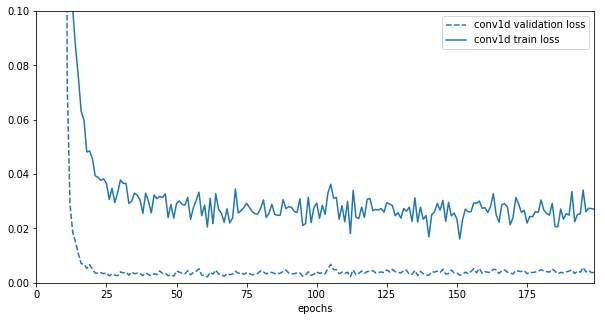

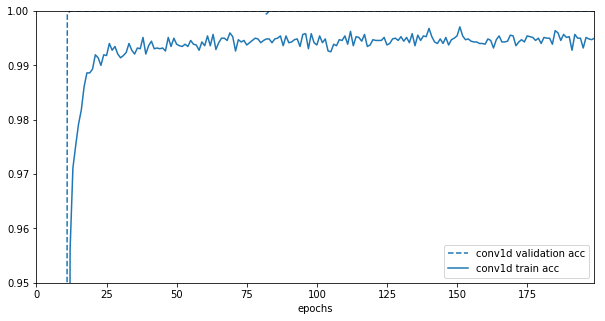

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_history(histories, key='loss', ymin=None, ymax=None):
    plt.figure(figsize=(10,5))    
    for name, history in histories:
        validation_plot = plt.plot(history.epoch, 
                                   history.history['val_' + key], 
                                   '--', 
                                   label=name + ' validation ' + key)
        plt.plot(history.epoch, 
                 history.history[key], 
                 color=validation_plot[0].get_color(),
                 label=name + ' train ' + key)
        plt.xlabel('epochs')
        plt.legend()
        plt.xlim([0, max(history.epoch)])
        if ymin is not None:
            plt.ylim(bottom=ymin)
        if ymax is not None:
            plt.ylim(top=ymax)
    
plot_history([('conv1d', history)], key='loss', ymin=0, ymax=0.1)
plot_history([('conv1d', history)], key='acc', ymin=0.95, ymax=1)

After convergence, the model performs very well! It's accuracy is far greater than 50%, which is the baseline accuracy associated with randomly predicting labels when the classes are balanced. This is expected since the model was designed to capture the way in which the training examples were labeled. 

Note: Training and validation losses (as computed above) may differ for a variety of reasons:

* regularization (see [here](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss) and ["because [this] penalty is only added at training time, the loss for this network will be much higher at training than at test time"](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#add_weight_regularization)
)
* the time during training at which the loss is evaluated (see [here](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss)) 

These confounding factors may be controlled for by making predictions in exactly the same way for training, validation and test sets, e.g. using `model.predict` in Keras. 

The high performance indicated by the classification accuracy is confirmed by examining the confusion matrix (for a given threshold on the probability output of the network) and the ROC (which exhaustively varies that threshold): 

Confusion matrix (threshold = 0.5):
 [[4511    0]
 [   0 4489]]


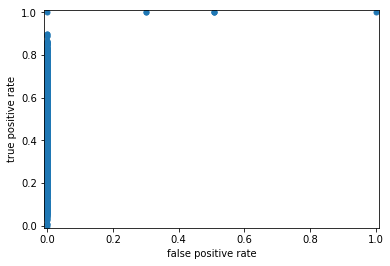

In [12]:
predicted_probabilities = model.predict(encoded_sequences)

from sklearn.metrics import confusion_matrix
threshold = 0.5
cm = confusion_matrix(y_true=observed_labels, 
                      y_pred=predicted_probabilities>threshold)
print('Confusion matrix (threshold = {}):\n'.format(threshold), cm)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(observed_labels, predicted_probabilities)
plt.plot(fpr, tpr, '.', ms=10)
_ = plt.xlabel('false positive rate')
_ = plt.ylabel('true positive rate')
_ = plt.xlim([-0.01, 1.01])
_ = plt.ylim([-0.01, 1.01])

## The convolution filter captures most of the DNA motif  

Since the model does so well at predicting the class labels, you'd expect that the convolution filter has evolved to match the motif, at least partially. Let's test that idea. 



filter:
[[-0.10998351 -0.5775335   0.02665563  0.6447328   0.31739864 -0.58295596]
 [ 0.08314294  0.540319    0.26208296  0.3415523   0.53123355  0.30546927]
 [ 0.07036136  0.5260216   0.14479302 -0.6876849   0.01773793  0.6223712 ]
 [ 0.3979342   0.29151022  0.3414374   0.38794047  0.2513338   0.2943823 ]]

[[ 0.03185978  1.0826863  -0.28744027 -0.5813333  -0.19856995  0.6160557 ]
 [ 1.3179237   0.57346076  0.46658093  0.6298198   1.1257818   0.60887533]
 [-0.18122454 -0.7996434   0.18820563  0.8832651  -0.24949065 -0.76258314]
 [ 1.111357    0.905367    1.1793551   0.59192216  0.32215     0.38281628]]

[[ 0.08870737 -0.35732138  0.08890685  0.7967047   0.03476148 -0.29702488]
 [ 0.2827265   0.24624328  0.32500756  0.40559104  0.3062866   0.45998904]
 [-0.1089952   0.2823917  -0.10153459 -0.2400808   0.1166556   0.7587836 ]
 [ 0.43279576  0.03290125  0.1803879   0.39515316  0.24450132  0.4754081 ]]


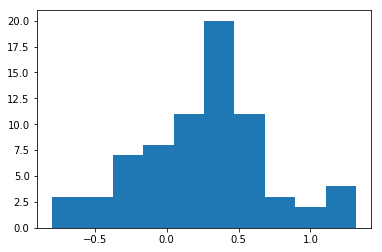

In [13]:
convolution_filter = model.layers[0].get_weights()[0].squeeze().transpose()
print('filter:')
break_point = 6
print(convolution_filter[:,:break_point])
print()
print(convolution_filter[:,break_point:2*break_point])
print()
print(convolution_filter[:,2*break_point:])
_ = plt.hist(convolution_filter.flatten()) 

convolution with motif 664.2458249367774


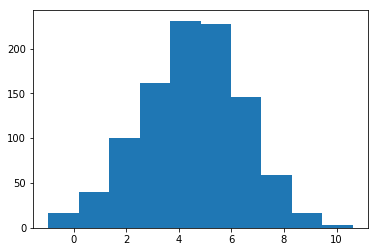

In [14]:
print('convolution with motif', np.sum(motif * convolution_filter))

def generate_random_motif():
    random_motif = \
    np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                               size=1, 
                               p=np.array([1,1,1,1])/4.0) 
              for position in range(motif.shape[1])]).transpose()
    return _one_hot_encode_conv1d(''.join(random_motif.squeeze())).transpose()

random_motifs_convolutions = []
for _ in range(1000): 
    random_motifs_convolutions.append(np.sum(generate_random_motif() * convolution_filter))
_ = plt.hist(random_motifs_convolutions) 

In [15]:
from keras.models import Model
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
example_index = 11
print('intermediate_layer_model') 
print(intermediate_layer_model.predict(np.array([encoded_sequences_test[example_index]])))
print('true label', observed_labels_test[example_index])

intermediate_layer_model
[[[5.720446 ]
  [4.7543044]
  [5.8615227]
  [5.9843416]
  [6.7975035]
  [6.733323 ]
  [5.401811 ]
  [4.592944 ]
  [6.2352686]
  [7.2642765]
  [4.622991 ]
  [3.7430124]
  [4.576876 ]]]
true label [0]


bias: 3.4800186157226562


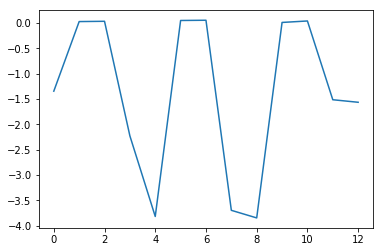

In [16]:
weights = model.layers[3].get_weights()[0]
_ = plt.plot(weights)
print('bias:', float(model.layers[3].get_weights()[1]))

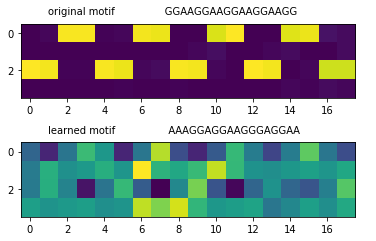

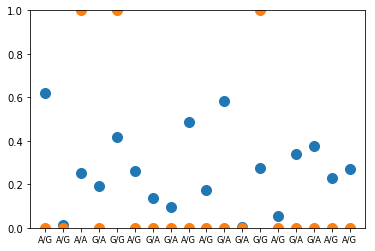

In [17]:
def motif_sequence(matrix, model=None): 
    nucleotides = ['A','C','G','T']
    if model: 
        bias = float(model.layers[3].get_weights()[1])
        arg = np.argmin if bias > 0.0 else np.argmax
    else: 
        arg = np.argmax
    return [nucleotides[arg(matrix[:, position])] 
            for position in range(matrix.shape[1])]

original_motif = np.array(motif_sequence(motif)) 
learned_motif = np.array(motif_sequence(convolution_filter, model=model))

plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(motif)
_ = plt.xticks(np.arange(0, 18, step=2))
_ = plt.text(1, -1, '{:<30}{:<40}'.format('original motif', ''.join(original_motif)))

plt.subplot(2, 1, 2)
plt.imshow(convolution_filter)
_ = plt.xticks(np.arange(0, 18, step=2))
_ = plt.text(1, -1, '{:<30}{:<40}'.format('learned motif', 
                                          ''.join(learned_motif)))

tick_labels, matches = \
list(zip(*[(nucleotide_learned + '/' + nucleotide_original, nucleotide_learned==nucleotide_original)
           for nucleotide_learned, nucleotide_original in zip(learned_motif, original_motif)]))    

def confidence(filter_values): 
    filter_values = np.sort(filter_values)
    distance_to_second_biggest = (filter_values[-1] - filter_values[-2])
    distance_to_smallest = (filter_values[-1] - filter_values[0])
    return distance_to_second_biggest/float(distance_to_smallest)

confidences = [confidence(convolution_filter[:, position]) 
               for position in range(convolution_filter.shape[1])]

plt.figure()
_ = plt.plot(confidences, '.', ms=20)
_ = plt.plot(matches, '.', ms=20)
_ = plt.xticks(range(len(tick_labels)), tick_labels, size='small')
_ = plt.ylim([0, 1])